# In this notebook, we will first highlight how blip image captioning works and explain the different blocks of the model in order to fully understand how it works.

In [ ]:
pip install transformers torch torchvision # packages installation

Note: you may need to restart the kernel to use updated packages.


In [4]:
import sys
import numpy as np
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import requests
sys.path.append("../")  
import src.RBM as rbm

In [3]:
import cv2
import matplotlib.pyplot as plt

def print_image(image_path):
    """"Cette fonction est permet d'afficher une image située à l'adresse image_path"""
    # Charger l'image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir BGR en RGB

    # Afficher l'image
    plt.imshow(image)
    plt.axis("off")
    plt.show()

We are testing blip-base captioning

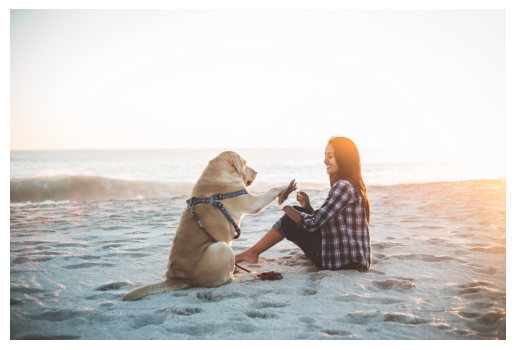

caption : a woman sitting on the beach with her dog


In [7]:
# The modèl and the processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Charge the image 
image_path = "../images/demo_BLIP.jpg"  
image = Image.open(image_path).convert("RGB")

# Image preprocessing 
inputs = processor(image, return_tensors="pt")

# captionning
output = model.generate(**inputs)

# print the image 
print_image("../images/demo_BLIP.jpg")

# decodage 
caption = processor.decode(output[0], skip_special_tokens=True)
print("caption :", caption)


In [ ]:
save_directory = "../models_saved/blip-image-captioning-base_local"

model.save_pretrained(save_directory)
processor.save_pretrained(save_directory)

[]

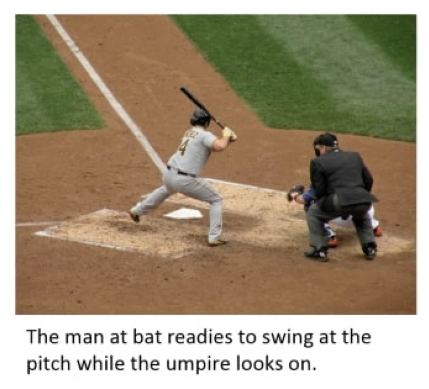

caption : a baseball player swinging at a ball during a game


In [8]:
image_path = "../images/the_battle_man.jpg" 

image = Image.open(image_path).convert("RGB")

print_image("../images/the_battle_man_o.jpg")

inputs = processor(image, return_tensors="pt")

output = model.generate(**inputs)

caption = processor.decode(output[0], skip_special_tokens=True)

print("caption :", caption)

Here we see the difference in description between the two texts. The Blip's description is less rich than the image's. Our approach aims to enrich this description.

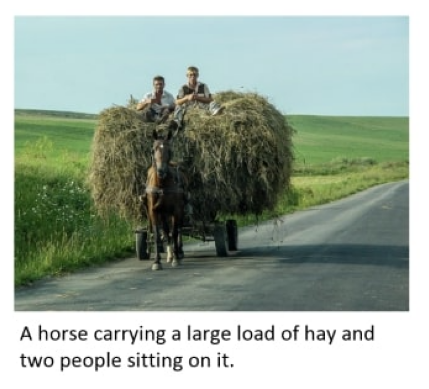

caption : a horse pulling a cart of hay down a country road


In [9]:
image_path = "../images/The_horse_carryer.jpg"  
image = Image.open(image_path).convert("RGB")
print_image("../images/The_horse_carryer_o.jpg")
inputs = processor(image, return_tensors="pt")

output = model.generate(**inputs)

caption = processor.decode(output[0], skip_special_tokens=True)
print("caption :", caption)

The image depicts: a horse carrying a large load of hay and two people sitting on it.

BLIP sees: a horse pulling a hay wagon on a country road.

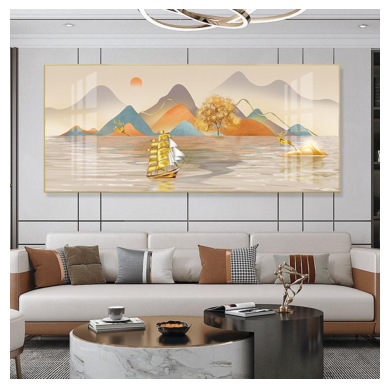

3 piece painting with mountains on the background


In [55]:
print_image("../images/salon_canape_tableau.jpg")
image_path = "../images/salon_canape_tableau.jpg"  
image = Image.open(image_path).convert("RGB")

# Générer la légende de l'image
inputs = processor(images=image, return_tensors="pt")

# Lancer la génération avec les paramètres adaptés
output = model.generate(**inputs, max_length=500, num_beams=5, do_sample=True, temperature=7.0, top_p=0.95)

# Décoder la sortie pour obtenir le texte
caption = processor.decode(output[0], skip_special_tokens=True)
print(caption)

Why not: a living room with a sofa, headphones, two tables, and a large painting on the wall showing a mountain range?

This is the goal of our study. Is it possible, without training the entire model, to improve the description with a Boltzmann machine to decompress the embeddings sent to the decoder and thus obtain a more detailed description of the image?

Let's see what an embedding looks like after encoding the model.

In [38]:
from transformers import BlipProcessor, BlipModel
import torch

# image
image = Image.open("../images/Bink_bed.jpg").convert("RGB")

# image preprocessing
inputs = processor(images=image, return_tensors="pt")

print(inputs)
# image embeddings
with torch.no_grad():
    encoder_outputs = model.vision_model(**inputs).last_hidden_state  # Embeddings

print(encoder_outputs.shape)  # Affiche la dimension des embeddings


{'pixel_values': tensor([[[[1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          ...,
          [1.9303, 1.9303, 1.9157,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9157,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9157,  ..., 1.9303, 1.9303, 1.9303]],

         [[2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          ...,
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749]],

         [[2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 2.1459],
          [2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 2.1459],
          [2.1459, 2.1459

In [39]:
print(inputs["pixel_values"].shape)

torch.Size([1, 3, 384, 384])


It's as if after each image pass in "embeddings" we collect a large tensor of size 577x768 for each image. It's very large as a tensor. It's the digital representation of the image.

Let's take a closer look at what's happening inside each block of the model. But first, let's look at what blocks we have in the model.

In [12]:
# what is in the model ?
for name, module in model.named_children():
    print(name)


vision_model
text_decoder


We see two blocks, vision_model and text_decoder. But let's take a closer loook once again.

In [13]:
for name, module in model.vision_model.named_children():
        print(name)
        

embeddings
encoder
post_layernorm


In [17]:
for name, module in model.vision_model.embeddings.named_children():
        print("In embeddings :", name)

for name, module in model.vision_model.encoder.named_children():
        print("In encoder :",name)

for name, module in model.vision_model.post_layernorm.named_children():
        print("In post_layernorm :",name) # this is an empty method, maybe just a metric

In embeddings : patch_embedding
In encoder : layers


In [40]:
# 1. visual Embeddings 
vision_embeddings = model.vision_model.embeddings(inputs["pixel_values"])
print("embeddings shape:", vision_embeddings.shape)

# 2. Encoder
vision_outputs = model.vision_model.encoder(vision_embeddings)
print("encoder output shape:", vision_outputs.last_hidden_state.shape)

# 3. Post-layernorm
post_normed = model.vision_model.post_layernorm(vision_outputs.last_hidden_state)
print("post_layernorm shape:", post_normed.shape)


embeddings shape: torch.Size([1, 577, 768])
encoder output shape: torch.Size([1, 577, 768])
post_layernorm shape: torch.Size([1, 577, 768])


Ok, we notice there is noting inside the post_layernorm (we will see why later)

Inside the embeddings there is a " patch_embedding "

and inside the encoder there is just some layers may be for image embeddings projection in the latent space.

Then let's take a closer look of the decoder

In [16]:
model_decoder = model.text_decoder
for name, module in model_decoder.named_children():
        print(name)

bert
cls


Bert is the decoder used for blip image captions! This is a good thing, as we already know a little about this model…

Next, for better understanding, we'll manually examine what we have after each of these steps.

# What about the decoder

In [51]:
# Define the initial text prompt
prompt = "a photo of"

# Tokenize the text prompt into input IDs (numerical tokens) for the decoder
inputs_text = processor(text=prompt, return_tensors="pt")

# Extract input IDs for the decoder
decoder_input_ids = inputs_text.input_ids

# Run the text decoder (BERT-like) conditioned on the visual features (post_normed)
# - input_ids: tokenized prompt
# - encoder_hidden_states: visual embeddings from the image
# - encoder_attention_mask: attention mask (all ones, since all visual tokens are valid)
outputs = model.text_decoder.bert(
    input_ids=decoder_input_ids,
    encoder_hidden_states=post_normed,
    encoder_attention_mask=torch.ones(post_normed.shape[:-1], dtype=torch.long)
)

# Output shape of the last hidden states from the decoder
print("decoder output shape:", outputs.last_hidden_state.shape)

# Pass the decoder's output through the classification head (cls)
# This head maps the hidden states to vocabulary logits (scores over possible next words)
logits = model.text_decoder.cls(outputs.last_hidden_state)

# Output shape of the logits: [batch_size, sequence_length, vocab_size]
print("cls logits shape:", logits.shape)


decoder output shape: torch.Size([1, 5, 768])
cls logits shape: torch.Size([1, 5, 30524])


### 🔍 Overview of BLIP Model Architecture Components

The BLIP model (`BlipForConditionalGeneration`) consists of two main blocks:

- `vision_model`: Handles image encoding
- `text_decoder`: Handles text decoding and caption generation

Below is a detailed breakdown of the key sub-modules and their roles:

| Module | Role |
|--------|------|
| `vision_model.embeddings` | Converts the input image into visual tokens (patch embeddings) |
| `vision_model.encoder` | Learns deep visual representations using a Vision Transformer (ViT) |
| `vision_model.post_layernorm` | Applies LayerNorm to stabilize and normalize visual features before passing them to the decoder |
| `text_decoder.bert` | A causal language model (BERT-like) that generates text conditioned on image features |
| `text_decoder.cls` | Outputs vocabulary logits for each token position (used for predicting the next word) |


# Now we will explore the contribution of RBM in the Blip image captioning model and then study the results that we observe.

In [57]:
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch
from PIL import Image
import torch.nn as nn

# image
image = Image.open("../images/the_battle_man.jpg")

# image processing
inputs = processor(images=image, return_tensors="pt")

# patching - visual_embeddings - visual_encoding - layer_norm
visual_features = model.vision_model(**inputs).last_hidden_state


In [58]:
visible_dim = 443136 
hidden_dim = 1000
sigma = 10
RBM =  rbm.GaussianBinaryRBM(visible_dim, hidden_dim, sigma)


In [ ]:
# Utilisation du texte conditionné sur les features latents pour la génération
# Ajouter un prompt de départ
prompt = "Il était une fois un mystère dans cette image,"

# Mettre en forme l'entrée pour la génération
generated_input = processor(prompt, return_tensors="pt").input_ids

# Ajouter les latent_features aux inputs pour conditionner la génération
# Tu pourrais aussi adapter la manière dont tu passes ces caractéristiques latentes, en fonction du modèle que tu choisis.
output = model.generate(
    input_ids=generated_input, 
    visual_embeds=latent_features.unsqueeze(0),  # Les latents doivent être redimensionnés si nécessaire
    max_length=50,
    num_beams=5,
    do_sample=True
)

# Décoder la sortie
generated_story = processor.decode(output[0], skip_special_tokens=True)
print(generated_story)


In [12]:
print(RBM)

GaussianBinaryRBM()


In [18]:
epoch = 30

for _ in range(epoch):
    # Applique le contraste de divergence sur le lot
    RBM.contrastive_divergence(encoder_outputs_flattened)
    
# Effectue la propagation avant pour obtenir les prédictions
encoder_pred = RBM.forward(encoder_outputs_flattened)

print(encoder_pred)

tensor([[ 1.,  1.,  1.,  ...,  1.,  1., -1.]], grad_fn=<TanhBackward0>)


In [20]:
encoder_pred_reconstructed = encoder_pred.view(1, 577, 768)
print(encoder_pred_reconstructed)


tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  0.4793,  1.0000,  1.0000],
         [ 1.0000, -0.9649, -1.0000,  ...,  1.0000, -1.0000, -1.0000],
         [ 1.0000,  1.0000, -0.9934,  ..., -0.0546, -1.0000, -1.0000],
         ...,
         [ 1.0000,  0.8375, -1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000, -1.0000, -1.0000,  ..., -1.0000,  1.0000, -1.0000],
         [ 1.0000, -1.0000,  1.0000,  ...,  1.0000,  1.0000, -1.0000]]],
       grad_fn=<ViewBackward0>)


In [21]:
# Affichage
caption = processor.decode(encoder_pred_reconstructed, skip_special_tokens=True)
print("Description générée :", caption)

TypeError: argument 'ids': 'list' object cannot be interpreted as an integer